# Comparing photometric fluxes and model spectra

In this tutorial, we will compare the photometric fluxes of the brown dwarf companion PZ Tel B with a synthetic spectrum from the ATMO grid.

## Initiating *species*

We start by importing *species*.

In [1]:
import species

And initiating the workflow with the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.init.SpeciesInit) class. This will create the configuration file and the HDF5 database.

In [2]:
species.SpeciesInit()

Initiating species v0.5.0... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


## Adding model spectra

We create now a [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) object which is used for importing various data into the database.

In [3]:
database = species.Database()

The spectra of ATMO are downloaded and added to the database with the [add_model](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_model) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database). This requires sufficient disk storage in the *data_folder* that is set in the configuration file. The full ATMO grid is downloaded but the `teff_range` parameter can be used to only import a certain $T_\mathrm{eff}$ range into the database.

In [4]:
database.add_model('atmo', teff_range=(2500., 3000.))

Unpacking ATMO model spectra (425 MB)... [DONE]
Please cite Phillips et al. (2020) when using ATMO in a publication
Reference URL: https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P/abstract
Wavelength range (um) = 0.4 -6000
Spectral resolution = 10000
Teff range (K) = 2500.0 - 3000.0
Adding ATMO model spectra... [DONE]                          
Grid points stored in the database:
   - Teff = [2500. 2600. 2700. 2800. 2900. 3000.]
   - log(g) = [2.5 3.  3.5 4.  4.5 5.  5.5]


## Adding companion data

Next, we add the distance and magnitudes of PZ Tel B to the database with the `add_companion`` method. This will automatically download the required filter profiles and a flux-calibrated spectrum of Vega. These are used to convert the magnitudes into fluxes.

In [5]:
database.add_companion('PZ Tel B', verbose=False)

Adding Vega spectrum... [DONE]
Adding object: PZ Tel B [DONE]


Alternatively, the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) can be used for manually adding magnitudes and spectra of an individual object. Before continuing, let's check the content of the database.

In [6]:
database.list_content()

Database content:
- filters: <HDF5 group "/filters" (2 members)>
	- Gemini: <HDF5 group "/filters/Gemini" (2 members)>
		- NICI.ED286: <HDF5 dataset "NICI.ED286": shape (387, 2), type "<f8">
			- det_type: energy
		- NIRI.H2S1v2-1-G0220: <HDF5 dataset "NIRI.H2S1v2-1-G0220": shape (129, 2), type "<f8">
			- det_type: energy
	- Paranal: <HDF5 group "/filters/Paranal" (12 members)>
		- NACO.H: <HDF5 dataset "NACO.H": shape (23, 2), type "<f8">
			- det_type: energy
		- NACO.J: <HDF5 dataset "NACO.J": shape (20, 2), type "<f8">
			- det_type: energy
		- NACO.Ks: <HDF5 dataset "NACO.Ks": shape (27, 2), type "<f8">
			- det_type: energy
		- NACO.Lp: <HDF5 dataset "NACO.Lp": shape (31, 2), type "<f8">
			- det_type: energy
		- NACO.Mp: <HDF5 dataset "NACO.Mp": shape (18, 2), type "<f8">
			- det_type: energy
		- NACO.NB405: <HDF5 dataset "NACO.NB405": shape (67, 2), type "<f8">
			- det_type: energy
		- SPHERE.IRDIS_D_H23_2: <HDF5 dataset "SPHERE.IRDIS_D_H23_2": shape (113, 2), type "<f8">
		

We see the various groups, subgroups, datasets, and attributes that are stored in the HDF5 database.

## Reading model spectra

Model spectra are read from the database by first creating an instance of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel). The model name and optionally a wavelength range are provided as arguments.

In [7]:
readmodel = species.ReadModel('atmo', wavel_range=(0.5, 10.))

Before extracting a spectrum, let's check which parameters are required for the ATMO model spectra.

In [8]:
readmodel.get_parameters()

['teff', 'logg']

And also the parameter boundaries of the grid that is stored in the database.

In [9]:
readmodel.get_bounds()

{'teff': (2500.0, 3000.0), 'logg': (2.5, 5.5)}

The parameters are provided in a dictionary for which we have to make sure that chose values are within the grid boundaries. The radius ($R_\mathrm{J}$) and distance (pc) will scale the emitted spectrum to the observer. Without these values, the spectrum fluxes are provided at the surface of the atmosphere.

In [10]:
model_param = {'teff': 2900., 'logg': 4.5, 'radius': 2.2, 'distance': 47.13}

We now use the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) to linearly interpolate the grid of spectra and store the extracted spectrum in a `ModelBox`. The spectrum is smoothed to a spectral resolution of $R = 100$.

In [11]:
modelbox = readmodel.get_model(model_param, spec_res=100., smooth=True)

## Reading companion data

The photometric data of PZ Tel B are also read from the database and stored in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

In [12]:
objectbox = database.get_object(object_name='PZ Tel B')

Getting object: PZ Tel B... [DONE]


## Synthetic photometry for all filters

For comparison, we create synthetic photometry from the extracted ATMO spectrum for all filters of PZ Tel B. The synthetic fluxes are stored in a [SynphotBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SynphotBox).

In [13]:
synphotbox = species.multi_photometry(datatype='model',
                                      spectrum='atmo',
                                      filters=objectbox.filters,
                                      parameters=model_param)

Calculating synthetic photometry... [DONE]


## Creating flux residuals

The [get_residuals](https://species.readthedocs.io/en/latest/species.util.html#species.util.phot_util.get_residuals) function is now used to calculate the difference between the observed fluxes and the synthetic fluxes from the model spectrum. The residuals are stored in a [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox).

In [14]:
res_box = species.get_residuals(datatype='model',
                                spectrum='atmo',
                                parameters=model_param,
                                objectbox=objectbox,
                                inc_phot=True,
                                inc_spec=False)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - Gemini/NICI.ED286: 1.35
   - Gemini/NIRI.H2S1v2-1-G0220: -0.02
   - Paranal/NACO.H: -0.54
   - Paranal/NACO.J: -0.19
   - Paranal/NACO.Ks: 0.85
   - Paranal/NACO.Lp: 0.02
   - Paranal/NACO.Mp: 5.45
   - Paranal/NACO.NB405: 0.31
   - Paranal/SPHERE.IRDIS_D_H23_2: 0.54
   - Paranal/SPHERE.IRDIS_D_H23_3: 0.00
   - Paranal/SPHERE.IRDIS_D_K12_1: 1.00
   - Paranal/SPHERE.IRDIS_D_K12_2: 1.00
   - Paranal/SPHERE.ZIMPOL_I_PRIM: -7.73
   - Paranal/SPHERE.ZIMPOL_R_PRIM: -3.96
Reduced chi2 = 10.05
Number of degrees of freedom = 11


## Opening Box objects

The [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) method can be used to view the content of any [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) object. For example, the [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) contains several attributes, including the wavelengths and fluxes.

In [15]:
modelbox.open_box()

Opening ModelBox...
model = atmo
type = None
wavelength = [ 0.49998877  0.50003831  0.50008785 ...  9.99834109  9.99933175
 10.0003225 ]
flux = [1.99712687e-15 2.00092575e-15 2.00491964e-15 ... 5.56173692e-17
 5.56061304e-17 5.55950840e-17]
parameters = {'teff': 2900.0, 'logg': 4.5, 'radius': 2.2, 'distance': 47.13, 'luminosity': 0.003114426265448587, 'mass': 59.04988128500266}
quantity = flux
contribution = None
bol_flux = None


Similarly, an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) contains a dictionary with the magnitudes and a dictionary with the fluxes.

In [16]:
objectbox.open_box()

Opening ObjectBox...
name = PZ Tel B
filters = ['Gemini/NICI.ED286', 'Gemini/NIRI.H2S1v2-1-G0220', 'Paranal/NACO.H', 'Paranal/NACO.J', 'Paranal/NACO.Ks', 'Paranal/NACO.Lp', 'Paranal/NACO.Mp', 'Paranal/NACO.NB405', 'Paranal/SPHERE.IRDIS_D_H23_2', 'Paranal/SPHERE.IRDIS_D_H23_3', 'Paranal/SPHERE.IRDIS_D_K12_1', 'Paranal/SPHERE.IRDIS_D_K12_2', 'Paranal/SPHERE.ZIMPOL_I_PRIM', 'Paranal/SPHERE.ZIMPOL_R_PRIM']
mean_wavel = {'Gemini/NICI.ED286': 1.5841803431418238, 'Gemini/NIRI.H2S1v2-1-G0220': 2.2447142746110718, 'Paranal/NACO.H': 1.6588090664617747, 'Paranal/NACO.J': 1.265099894847529, 'Paranal/NACO.Ks': 2.144954491491888, 'Paranal/NACO.Lp': 3.8050282724280526, 'Paranal/NACO.Mp': 4.780970919324577, 'Paranal/NACO.NB405': 4.055862923806052, 'Paranal/SPHERE.IRDIS_D_H23_2': 1.5863509078883227, 'Paranal/SPHERE.IRDIS_D_H23_3': 1.6661442175885708, 'Paranal/SPHERE.IRDIS_D_K12_1': 2.1038552712775034, 'Paranal/SPHERE.IRDIS_D_K12_2': 2.255172356268582, 'Paranal/SPHERE.ZIMPOL_I_PRIM': 0.7843997176190827,

The attributes in a [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) object can be extracted for further analysis or creating plots. For example, to extract the array with wavelengths from the [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox):

In [17]:
modelbox.wavelength

array([ 0.49998877,  0.50003831,  0.50008785, ...,  9.99834109,
        9.99933175, 10.0003225 ])

## Plotting model spectrum and photometric fluxes

Finally, we will combine the model spectrum and the photometric fluxes in a plot with [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum). A list with [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) objects is provided as an argument of `boxes`. These are interpreted accordingly by the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function. Also a list with filter names can be provided as argument of `filters` to show the filter profiles. The [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) is provided as arguments of `residuals`. Finally, the optional argument of `plot_kwargs` contains a list with optional dictionaries to tune the visualization of the plotted data. The number of items in the list of `plot_kwargs` should be equal to the number of items in the list of `boxes`. For the [SynphotBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SynphotBox), we can set the item in `plot_kwargs` to `None` such that the marker design is based on the data from [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

The blue squares are the photometric fluxes of PZ Tel B and the open squares are the synthetic photometry computed from the model spectrum. The residuals are shown relative to the uncertainties on the fluxes.

Plotting spectrum... [DONE]


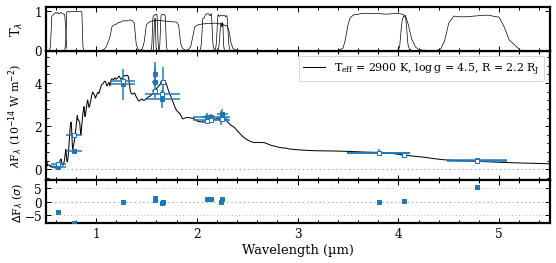

In [18]:
species.plot_spectrum(boxes=[modelbox, objectbox, synphotbox],
                      filters=objectbox.filters,
                      residuals=res_box,
                      plot_kwargs=[{'ls': '-', 'lw': 1., 'color': 'black'},
                                   {'Gemini/NICI.ED286': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Gemini/NIRI.H2S1v2-1-G0220': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.H': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.J': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.Ks': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.Lp': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.Mp': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/NACO.NB405': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_H23_2': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_H23_3': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_K12_1': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_K12_2': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/SPHERE.ZIMPOL_I_PRIM': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                    'Paranal/SPHERE.ZIMPOL_R_PRIM': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'}},
                                   None],
                      xlim=(0.5, 5.5),
                      ylim=(-5e-15, 5.5e-14),
                      ylim_res=(-8, 8),
                      scale=('linear', 'linear'),
                      offset=(-0.45, -0.04),
                      legend={'loc': 'upper right', 'fontsize': 11.},
                      figsize=(7., 3.),
                      quantity='flux',
                      output=None)